# 空间数据分析之空间回归
## 2018-2020纽约枪击犯罪事件分析

本实验基于纽约2018-2020的枪击犯罪数据，实现空间相关性分析，选取人口（pop）、收入（income）、平均就业率（employ）、教育程度（edu）四个参数进行地理空间加权回归（GWR，MGWR）模型的参数估计

### 1 数据处理

In [3]:
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
import matplotlib as mpl
import mapclassify as mc
import shapely as shp
from legendgram import legendgram
import palettable.matplotlib as palmpl
import esda
import libpysal as lps
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams["font.family"]="sans-serif"
plt.rcParams['axes.unicode_minus'] =False

导入数据，并投影到WGS 84

In [5]:
zone = gpd.read_file('shoot.shp')
zone = zone.to_crs(epsg=4326)
zone.crs
zone[['GEO_ID','shoot_coun','pop','income','employ','edu','geometry']].head(2)

,GEO_ID,shoot_coun,pop,income,employ,edu,geometry
0,1400000US36085007700,5.0,1417.333333,66617.666667,47.733333,13.440145,"MULTIPOLYGON (((-74.08710 40.64033, -74.08721 ..."
1,1400000US36085000900,0.0,1697.666667,70920.000000,57.700000,24.632207,"MULTIPOLYGON (((-74.08720 40.63990, -74.08553 ..."


In [6]:
wq =  lps.weights.Queen.from_dataframe(zone)
wq.transform = 'r'
y = zone['shoot_coun']
ylag = lps.weights.lag_spatial(wq, y)

('WARNING: ', 1662, ' is an island (no neighbors)')
('WARNING: ', 2080, ' is an island (no neighbors)')


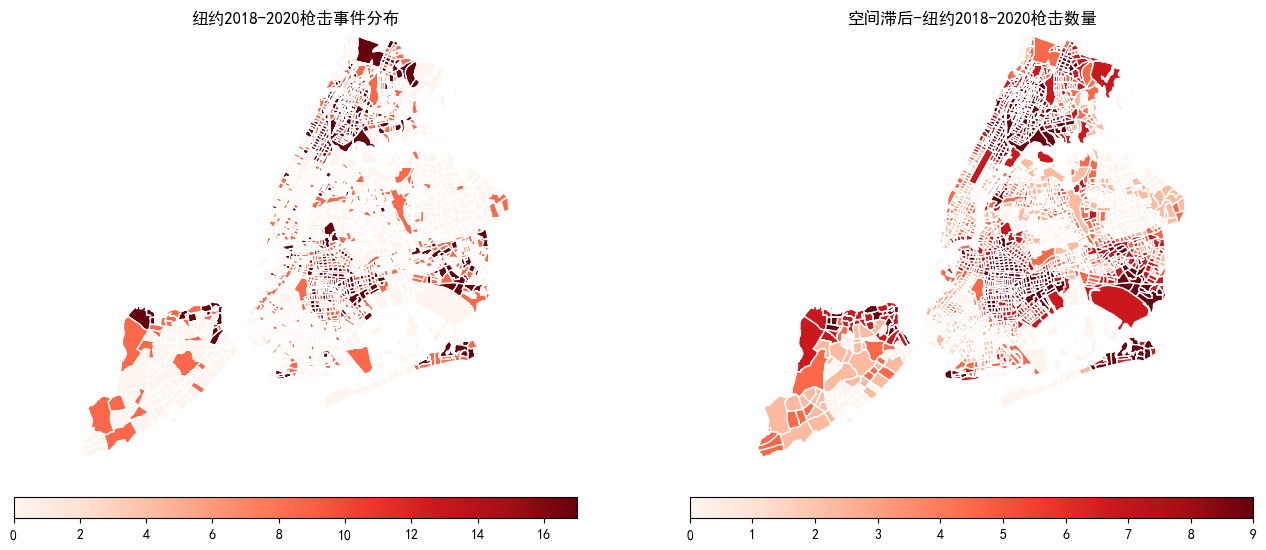

In [7]:
zone['lag_shoot_count'] = ylag
f, ax = plt.subplots(1, 2, figsize=(16, 10))
cmap = mpl.cm.Reds
norm = mpl.colors.Normalize(vmin=zone['shoot_coun'].min(), vmax=zone['shoot_coun'].max())

zone.plot(column='shoot_coun', ax=ax[0], edgecolor='white',
          scheme="quantiles", k=5, cmap=cmap, legend=False)
ax[0].axis(zone.total_bounds[np.asarray([0, 2, 1, 3])])
ax[0].set_title("纽约2018-2020枪击事件分布")
ax[0].axis('off')

divider = make_axes_locatable(ax[0])
cax = divider.append_axes("bottom", size="5%", pad=0.4)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar = f.colorbar(sm, cax=cax, orientation='horizontal')

norm = mpl.colors.Normalize(vmin=zone['lag_shoot_count'].min(), vmax=zone['lag_shoot_count'].max())
zone.plot(column='lag_shoot_count', ax=ax[1], edgecolor='white',
          scheme='quantiles', cmap=cmap, legend=False)
ax[1].axis(zone.total_bounds[np.asarray([0, 2, 1, 3])])
ax[1].set_title("空间滞后-纽约2018-2020枪击数量")
ax[1].axis('off')

divider = make_axes_locatable(ax[1])
cax = divider.append_axes("bottom", size="5%", pad=0.4)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar = f.colorbar(sm, cax=cax, orientation='horizontal')
plt.show()

### 2 空间自相关（全局，局部）

**全局空间自相关主要用于描述区域单元某种现象的整体空间分布情况，以判断该现象在空间上是否存在聚集性。**

**全局莫兰指数：**
$$
\mathrm{Moran's}I=\frac{\sum_{i=1}^{n}\sum_{j=1}^{n}w_{ij}(x_{i}-\overline{x})(x_{j}-\overline{x})}{S^{2}\sum_{i=1}^{n}\sum_{j=1}^{n}w_{ij}}
$$

其中方差为$S^{2}=\frac{1}{n}\sum_{i=1}^{n}(x_{i}-\overline{x})^{2}$，$\overline{x}=\frac{1}{n}\sum_{i=1}^{n}x_{i}$， $x_{i}为第{i}地区的观测值；n为地区总数；w_{ij}为空间权重矩阵中第i行第j列的一个元素，以度量区域i与区域j之间的距离；\sum_{i=1}^n\sum_{j=1}^nw_{ij}为所有空间权重之和$，$如果空间权重为行标准化，则\sum_{i=1}^n\sum_{j=1}^nw_{ij}为n$


$$
Z_{\alpha}=\frac{I-E(I)}{\sqrt{\mathrm{Var}(I)}}
$$
利用Z值计算事物是否具有空间相关性


**局部空间自相关就是通过计算每一个空间单元与邻近单元就某一属性的相关程度，对各局部区域中的属性信息进行分析，探究整个区域上同一属性的变化是否平滑(均质)或者存在突变(异质)。**

**局部莫兰指数:**
$$
I_{i}=\frac{(x_{i}-\overline{x})}{S^{2}}\sum_{j}w_{ij}(x_{j}-\overline{x})
$$

其中：
$$
S^{2}=\frac{1}{n}\sum_{i=1}^{n}(x_{i}-\overline{x})^{2}\quad\overline{x}=\frac{1}{n}\sum_{i=1}^{n}x_{i}
$$

正的Ⅰ表示该空间单元与邻近单元的观测属性呈现正相关(高值集聚或者低值集聚)，表示一个高值被高值所包围(高-高)或是一个低值被低值所包围(低-低);负的I表示一个高值被低值所包围(高-低)或是一个低值被高值所包围(低-高)。

通过纽约枪击事件分布图，我们可以观查到纽约中部，北部枪击事件较为密集，接下来利用全局莫兰指数和局部莫兰指数定量分析纽约枪击事件的空间相关性

In [8]:
yb = y > y.median()
labels = ["0 低于平均值", "1 高于平均值"]
yb = [labels[i] for i in 1*yb]
zone['yb'] = yb

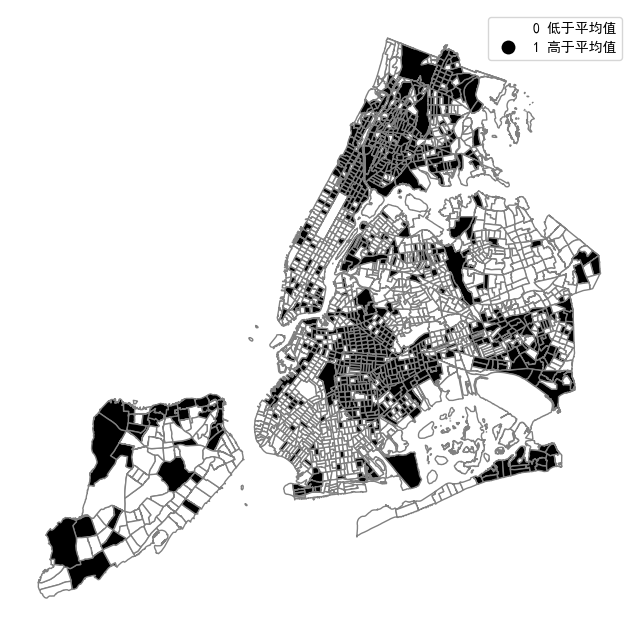

In [9]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'aspect': 'equal'})
zone.plot(column='yb', cmap='binary', edgecolor='grey', legend=True, ax=ax)
ax.axis("off")
plt.show()


In [10]:
y =zone['shoot_coun'] 
yb = 1 * (y > y.median())
wq = lps.weights.Queen.from_dataframe(zone)
wq.transform = 'b'
np.random.seed(12345)
jc = esda.join_counts.Join_Counts(yb, wq)
print(f"BB (Both Binary 1): {jc.bb}")
print(f"WW (Both Binary 0): {jc.ww}")
print(f"BW (One of Each): {jc.bw}")
print("jc.meanbb:",jc.mean_bb)

BB (Both Binary 1): 1795.0
WW (Both Binary 0): 2985.0
BW (One of Each): 2057.0
jc.meanbb: 1088.3813813813813


全局莫兰指数通过检验

p值 0.001


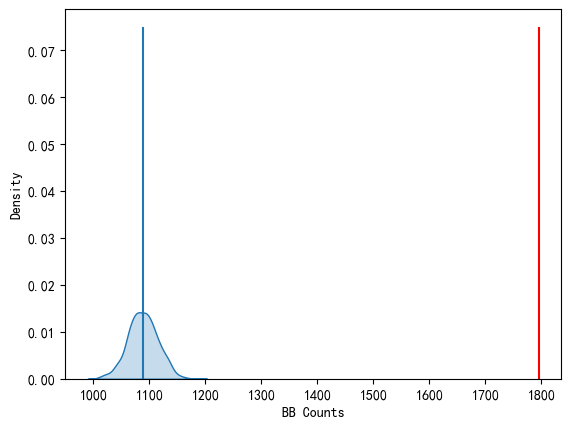

In [11]:
import seaborn as sbn
sbn.kdeplot(jc.sim_bb, shade=True)
plt.vlines(jc.bb, 0, 0.075, color='r')
plt.vlines(jc.mean_bb, 0,0.075)
plt.xlabel('BB Counts')

print("p值",jc.p_sim_bb)

In [12]:
wq.transform = 'r'
y = zone['shoot_coun']
np.random.seed(12345)
mi = esda.moran.Moran(y, wq)
mi.I

('WARNING: ', 1662, ' is an island (no neighbors)')
('WARNING: ', 2080, ' is an island (no neighbors)')


0.3985436444329907

P值 0.001


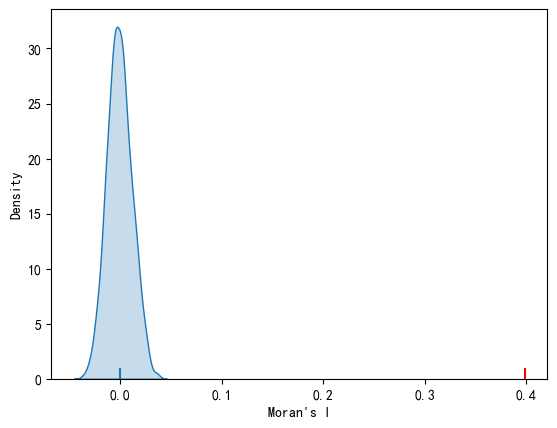

In [13]:
import seaborn as sbn
sbn.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 1, color='r')
plt.vlines(mi.EI, 0,1)
plt.xlabel("Moran's I")
print("P值",mi.p_sim)

In [14]:
np.random.seed(1000)
wq.transform = 'r'
lag_shoot = lps.weights.lag_spatial(wq,zone['shoot_coun'])

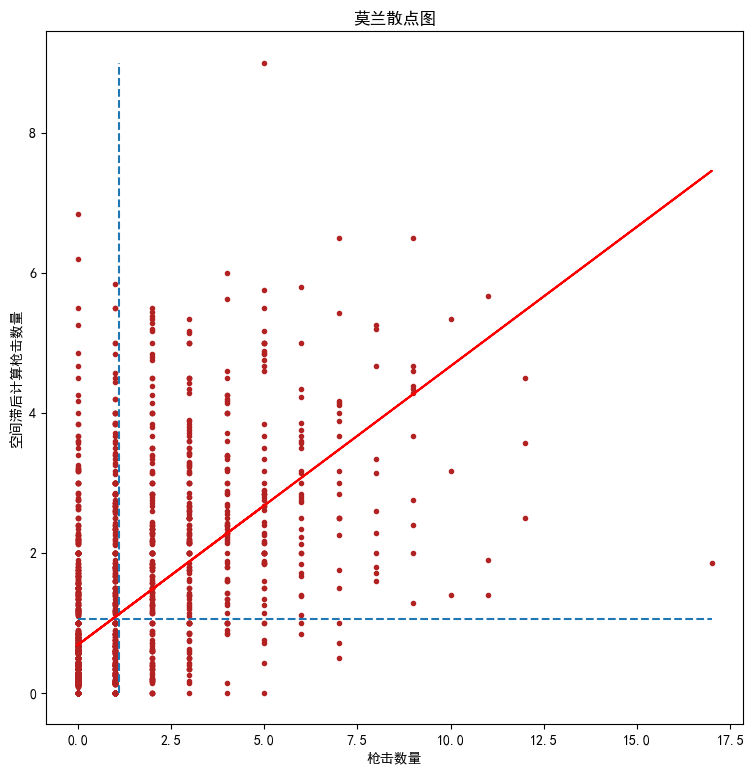

In [15]:
shoot = zone['shoot_coun']
b, a = np.polyfit(shoot, lag_shoot, 1)
f, ax = plt.subplots(1, figsize=(9, 9))
plt.plot(shoot, lag_shoot, '.', color='firebrick')
plt.vlines(lag_shoot.mean(), lag_shoot.min(), lag_shoot.max(), linestyle='--')
plt.hlines(shoot.mean(), shoot.min(), shoot.max(), linestyle='--')
plt.plot(shoot, a + b*shoot, 'r')
plt.title('莫兰散点图')
plt.ylabel('空间滞后计算枪击数量')
plt.xlabel('枪击数量')
plt.show()

In [16]:
wq = lps.weights.Queen.from_dataframe(zone)
wq.transform = 'r'

('WARNING: ', 1662, ' is an island (no neighbors)')
('WARNING: ', 2080, ' is an island (no neighbors)')


In [17]:
li = esda.Moran_Local(y, wq)

In [18]:
sig = 1 * (li.p_sim < 0.05)
hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)
spots = hotspot + coldspot + doughnut + diamond

spot_labels = [ '0 不显著', '1 高-高(HH)', '2 低-高(LH)', '3 低-低(LL)', '4 高-低(HL)']
labels = [spot_labels[i] for i in spots]

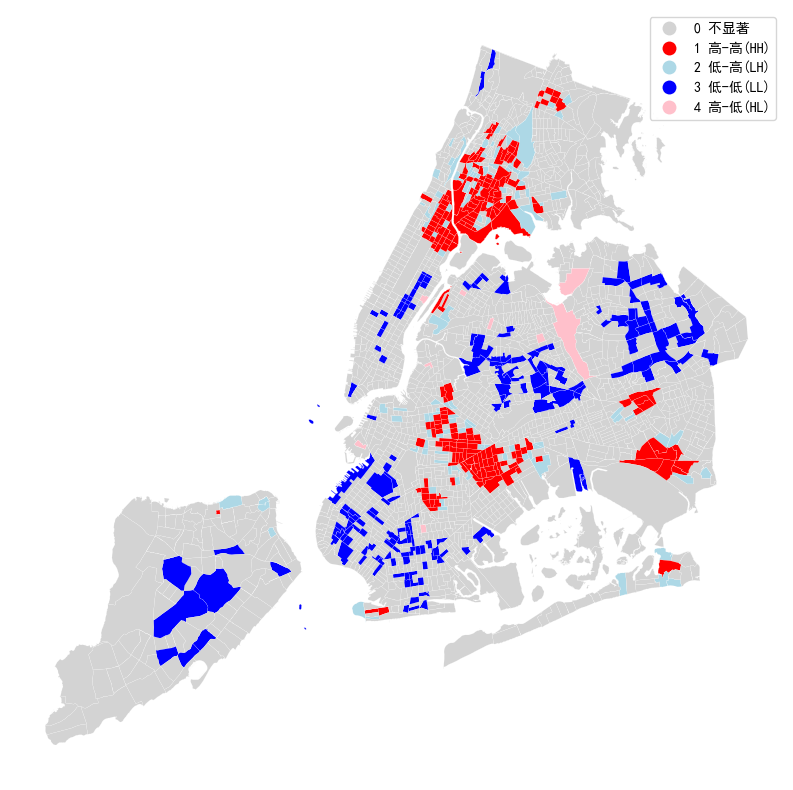

In [19]:
from matplotlib import colors
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue', 'pink'])
f, ax = plt.subplots(1, figsize=(10, 10))
zone.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

#### 空间自相关结论


在实验中，对纽约市2018至2020年期间的枪击事件进行了全局空间自相关和局部空间相关性分析。通过计算得出的全局莫兰指数为0.39，这表明在所研究的时间框架内，纽约市的枪击事件呈现出中等程度的空间相关性。这表明枪击事件在空间分布上并非完全随机，而是在某种程度上趋向于聚集。

进一步的分析，包括局部莫兰指数的计算及LISA图的绘制，揭示了局部的空间分布模式。发现，纽约市的中部和北部地区出现了“高-高”聚集模式，即这些区域及其邻近区域的枪击事件发生率较高。相对地，纽约市的南部和东北部地区则显示出“低-低”聚集模式，这意味着这些地区及其周围的枪击事件发生率较低。

这些发现为理解纽约市枪击事件的空间分布特征提供了重要视角，同时为制定针对性的预防措施和政策提供了数据支持。通过识别出枪击事件的空间聚集模式，相关部门可以更有效地集中资源和注意力，以减少这些高发区的暴力事件。


### 3 地理加权回归（GWR、MGWR）

为何要引入地理加权回归的概念，是因为空间异质性的存在

空间异质性一方面在于各种事物和现象在空间上缺乏平稳的结构，另一方面也在于空间单元本身不是均质的，在面积和形状上具有较大差别。在空间数据分析中，变量的观测值(数
据)一般都是以某给定的空间单元为抽样单位得到的，随着地理位置的变化，变量间的关系或者结构都会发生变化，这种因地理位置的变化而引起的变量间关系或结构的变化称为空间非平稳性。
空间非平稳性普遍存在于空间数据中，如果采用普通线性回归，结果可能较差，因此本实验使用GWR，MGWR对纽约市枪击进行回归，并分析结果差异。

本实验所使用数据字段：

**shoot_coun：2018-2020年的枪击案数量**

**pop：2018-2020年的人口数平均数**

**income：2018-2020年的家庭收入平均数**

**employ：2018-2020年的平均就业率**

**edu：2018-2020年的平均教育水平，用本科以上学历的人口占比衡量**

#### Geospatial Weighted Regression Model(GWR)

GWR利用局部加权最小二乘方法进行逐点参数估计，其中权是回归点所在的地理空间位置到其它各观测点的地理空间位置之间的距离函数,公式如下：

$$
y_{i}=\beta_{0}(u_{i},\nu_{i})+\sum_{k=1}^{p}\beta_{k}(u_{i},\nu_{i})x_{ik}+\varepsilon_{i}
$$
其中，$(u_{i},\nu_{i})为第i个采样点的坐标；beta_{k}(u_{i},\nu_{i})为第i个采样点上第k个回归参数，是地理位置的函数，\varepsilon_{i}为第i个区域的随机误差$


In [20]:
import numpy as np
from mgwr.sel_bw import Sel_BW
from mgwr.gwr import GWR, MGWR
import pandas as pd
import libpysal as ps

从数据集的geometry属性中计算每个区域的质心坐标，以后续计算带宽和空间权重

In [21]:
zone['centro']=zone.centroid
zone['X']=zone.centro.x
zone['Y']=zone.centro.y
coords = list(zip(zone['X'],zone['Y']))

将geopandas的数据框格式转换为数组格式，并进行数据标准化

In [22]:
y = np.array(zone['shoot_coun']).reshape((-1,1))
pop = np.array(zone['pop']).reshape((-1,1))
income = np.array(zone['income']).reshape((-1,1))
employ = np.array(zone['employ']).reshape((-1,1))
edu = np.array(zone['edu']).reshape((-1,1))
X = np.hstack([pop, income,employ, edu])

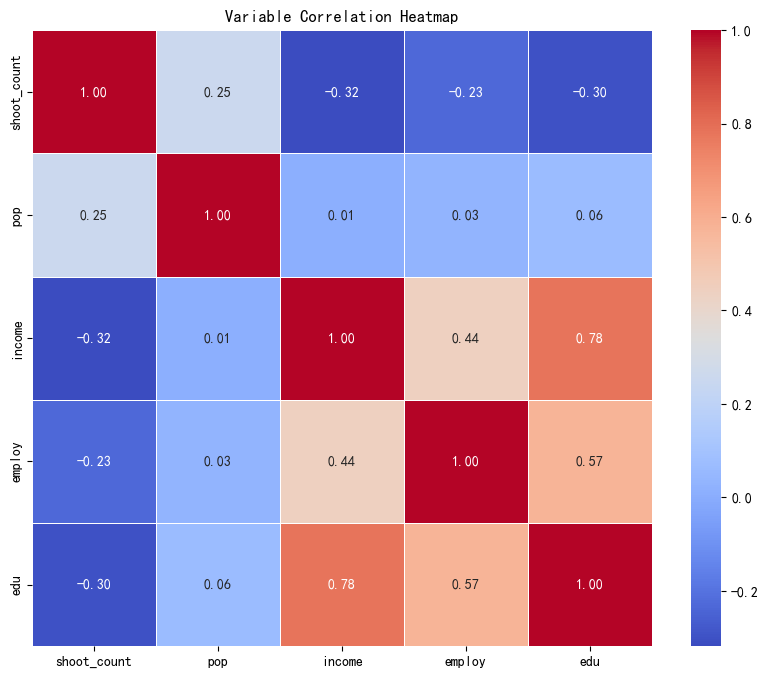

In [29]:
data = np.hstack([y, pop, income, employ, edu])
df = pd.DataFrame(data, columns=['shoot_count', 'pop', 'income', 'employ', 'edu'])
corr = df.corr()
plt.figure(figsize=(10, 8)) 
sbn.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Variable Correlation Heatmap')
plt.show()

采用自动搜索以获取最优带宽，同时采用模型默认的adaptive bandwidth确定核函数（地理空间权重），空间权重计算公式如下：
$$
\left.\text{Bi-square}\quad w_{ij}=\left\{\begin{array}{cc}(1-(d_{ij}/b)^2)^2&\quad\text{if}| d_{ij}|<b,\\0&\quad\text{otherwise}\end{array}\right.\right.
$$

In [23]:
X = (X - X.mean(axis=0)) / X.std(axis=0)
y = y.reshape((-1,1))
y = (y - y.mean(axis=0)) / y.std(axis=0)
sel = Sel_BW(coords, y, X)
bw = sel.search()
print('bw:', bw)
gwr = GWR(coords, y, X, bw)
gwr_results = gwr.fit()
print('aicc:', gwr_results.aicc)
print('ENP:', gwr_results.ENP)
print('sigma2:', gwr_results.sigma2)

bw: 98.0
aicc: 4958.978176802648
ENP: 273.24664759284127
sigma2: 0.48167672342090784


In [24]:
selector=Sel_BW(coords,y,X,multi=True,constant=True)
bw2 = selector.search(multi_bw_min=[2],multi_bw_max=[159])
mgwr = MGWR(coords,y,X,selector,constant=True)
mgwr_results = mgwr.fit()

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
mgwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                2194
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1788.638
Log-likelihood:                                                   -2889.065
AIC:                                                               5788.129
AICc:                                                              5790.168
BIC:                                                             -15052.394
R2:                                                                   0.185
Adj. R2:                                                              0.183

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [25]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                2194
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1788.638
Log-likelihood:                                                   -2889.065
AIC:                                                               5788.129
AICc:                                                              5790.168
BIC:                                                             -15052.394
R2:                                                                   0.185
Adj. R2:                                                              0.183

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

上表的一个全局回归结果就是最小二乘法结果，最小二乘法的R2仅为0.185，而GWR的为0.578，表明GWR的拟合优度要显著高于最小二乘法。解释GWR的参数时，要结合每个参数的空间值来解释，下面将四个自变量的回归参数空间分布图绘制如下。

Text(0.5, 1.0, 'edu coef.')

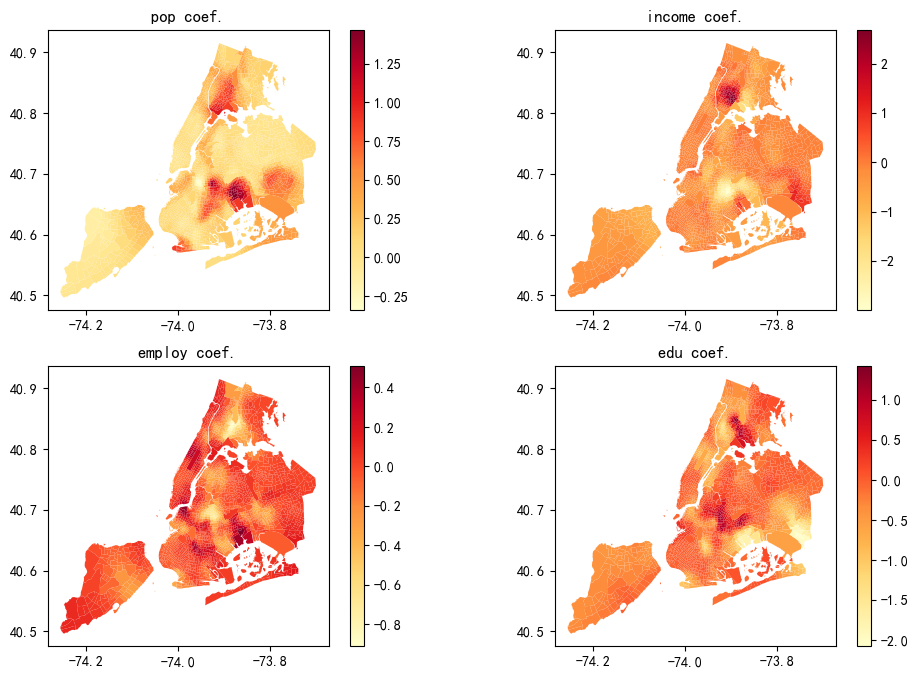

In [30]:
f, ax = plt.subplots(2, 2, figsize=(12, 8))
zone['pop_par'] = gwr_results.params[:, 1]
zone['income_par'] = gwr_results.params[:, 2]
zone['employ_par'] = gwr_results.params[:, 3]
zone['edu_par'] = gwr_results.params[:, 4]

ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 2, 3)
ax4 = plt.subplot(2, 2, 4)

cmap_choice = 'YlOrRd'
zone.plot('pop_par', ax=ax1, legend=True, cmap=cmap_choice)
ax1.set_title("pop coef.")
zone.plot('income_par', ax=ax2, legend=True, cmap=cmap_choice)
ax2.set_title("income coef.")
zone.plot('employ_par', ax=ax3, legend=True, cmap=cmap_choice)
ax3.set_title("employ coef.")
zone.plot('edu_par', ax=ax4, legend=True, cmap=cmap_choice)
ax4.set_title("edu coef.")


#### 结论